In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

from sklearn.linear_model import LinearRegression

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [96]:
df = pd.read_csv(
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv', 
    header=None, 
    parse_dates=[0], 
    dtype={1: np.float16}, 
    names=['date', 'level_ppm']
)
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


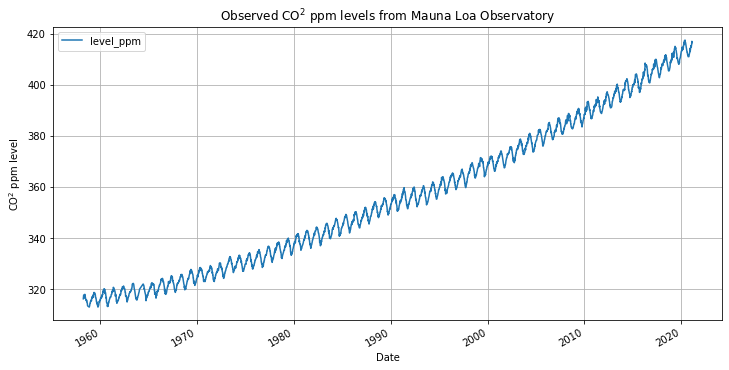

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [98]:
df['ordinal'] = df['date'].apply(datetime.toordinal)
df.head()

,date,level_ppm,ordinal
0,1958-03-29,316.25,714867
1,1958-04-05,317.25,714874
2,1958-04-12,317.75,714881
3,1958-04-19,317.50,714888
4,1958-04-26,316.50,714895


In [7]:
last_date = date(2060, 2, 1)
future_dates = pd.date_range(start=max(df['date']),end=last_date, freq='7d').to_series()
future_dates_ordinal = future_dates.apply(datetime.toordinal)
stan_data = {
    'N': len(df),
    'y': df['level_ppm'],
    'x': df['ordinal'],
    'nFutureCount': len(future_dates),
    'futureDays': future_dates_ordinal
}
to_predict_dates = df['date'].append(future_dates)
to_predict = to_predict_dates.apply(datetime.toordinal)

In [8]:
# Generate starting points for the models
lr = LinearRegression(n_jobs=-1)
lr.fit(
    X = df[['ordinal']],
    y = df[['level_ppm']]
)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [17]:
%%time
bad_stan:str = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;  // Ordinal date
    int<lower=1> nFutureCount;
    vector[nFutureCount] futureDays; // The future days to make predictions for
}

parameters {
    // Linear relationship
    real<lower=-10000, upper=10000>t_intercept;
    real<lower=0, upper=1>t_coef;  // Prior knowledge informs us of increasing c02 levels
    // Seasonal variation
    real<lower=0, upper=5> c2;
    real<lower=-2, upper=2> c3;
    real<lower=0>sigma;  // Standard deviation has to be positive
}

model {
    t_intercept ~ cauchy(-2800, 100);
    t_coef ~ cauchy(0.005, 0.01);
    c2 ~ cauchy(2.5, 1);
    c3 ~ cauchy(0, 1);
    y ~ normal(
        t_intercept + t_coef*x + c2 * cos(2 * pi() * x / 365.25 + c3),
        sigma
    );
}

generated quantities {
   real x_future[nFutureCount];
   for (t in 1:nFutureCount){
       x_future[t] = normal_rng(
           t_intercept + t_coef*(futureDays[t]) + c2 * cos(2 * pi() * (futureDays[t]) / 365.25 + c3),
           sigma
       );
   }
}
"""
bad_stan_model = pystan.StanModel(model_code=bad_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e09ee87c492d075e470a0e6350380faa NOW.


CPU times: user 1.41 s, sys: 92.9 ms, total: 1.51 s
Wall time: 59.2 s


In [18]:
%%time
bad_parameters = ['t_intercept', 't_coef', 'c2', 'c3', 'sigma']
bad_results = bad_stan_model.sampling(
    data=stan_data,
    control = {"max_treedepth": 15},
    init=[{
        't_intercept': lr.intercept_[0],
        't_coef': lr.coef_[0][0]
    }] * 4
)
print(bad_results.stansummary(pars=bad_parameters))
bad_samples = bad_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_e09ee87c492d075e470a0e6350380faa.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_intercept  -2812    0.26   7.61  -2827  -2817  -2812  -2806  -2797    891    1.0
t_coef      4.4e-3  3.5e-7 1.0e-5 4.3e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3    891    1.0
c2            2.83  1.8e-3    0.1   2.63   2.76   2.83   2.89   3.02   3029    1.0
c3           -1.66  7.8e-4   0.04  -1.73  -1.68  -1.66  -1.64  -1.59   2176    1.0
sigma          4.0  8.2e-4   0.05    3.9   3.97    4.0   4.03   4.09   3609    1.0

Samples were drawn using NUTS at Sun Apr 25 13:38:16 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 11.8 s, sys: 2.18 s, total: 13.9 s
Wall time: 40min 58s


In [19]:
%%time
pystan.check_hmc_diagnostics(bad_results)

CPU times: user 7.26 s, sys: 30.3 ms, total: 7.29 s
Wall time: 7.33 s


{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

In [9]:
def get_parameter(parameter:str, results, func = np.mean) -> float:
    return np.mean(results[parameter])

In [21]:
# Model parameters
bad_t_intercept = get_parameter('t_intercept', bad_results)
bad_t_coef = get_parameter('t_coef', bad_results)
bad_c2 = get_parameter('c2', bad_results)
bad_c3 = get_parameter('c3', bad_results)

In [22]:
# Stan model future predictions output
bad_prediction = bad_samples['x_future']

# Compute 95% interval of the predicted values
bad_prediction_interval = np.percentile(bad_prediction, axis=0, q=[2.5, 97.5])

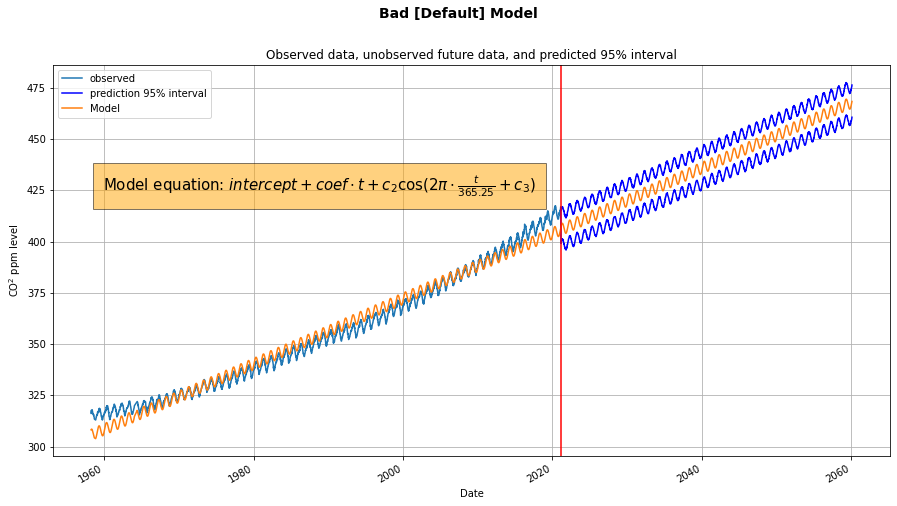

In [23]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = bad_t_intercept + bad_t_coef* to_predict + bad_c2 * np.cos(2 * np.pi * to_predict / 365.25 + bad_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1959, 11, 1), 425, 
    r'Model equation: $intercept + coef \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=15, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()

In [39]:
np.exp(df['ordinal']*0.000001)

0       2.043915
1       2.043929
2       2.043943
3       2.043958
4       2.043972
          ...   
3205    2.091342
3206    2.091357
3207    2.091371
3208    2.091386
3209    2.091401
Name: ordinal, Length: 3210, dtype: float64

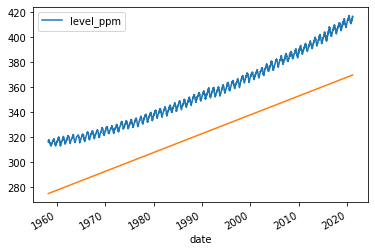

In [31]:
df.plot('date', 'level_ppm')
plt.plot(
    df['date'],
    -2800 + 0.004 * df['ordinal'] + 0.5 * np.exp(np.log(df['ordinal']) * 0.45)
)

In [40]:
%%time
good_stan: str = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;  // Ordinal date
    int<lower=1> nFutureCount;
    vector[nFutureCount] futureDays; // The future days to make predictions for
}

parameters {
  //posterior parameters 
      // Trend relationship
    real<lower=0> t_intercept;
    real<lower=0> a;  // (scaling factor) Cannot be below 0
    real<lower=0> b; // Prior knowledge informs us of increasing CO2 levels
    // real<lower=1, upper=5> c;
    // Seasonal variation
    real c2;
    real<lower=-2, upper=2> c3;
    real<lower=0>sigma;  // Standard deviation has to be positive
}

model {
  //non-informative gaussian priors
  b ~ normal(0, 5); 
  t_intercept ~ normal(300, 3);

  //likelihood function 
    for(t in 1:N){
      y[t]~normal(
        t_intercept + a*x[t] + b*x[t]^1.5 + c2 * cos(2 * pi() * x[t] / 365.25 + c3), 
        sigma
      );
    }

}
//for predictions into the future
generated quantities {
  real x_future[nFutureCount];
  for (t in 1:nFutureCount){
    x_future[t] = normal_rng(
        t_intercept + a*futureDays[t] + b*futureDays[t]^1.5 + c2 * cos(2 * pi() * futureDays[t] / 365.25 + c3),
        sigma
    );
  }
}
"""
good_stan_model = pystan.StanModel(model_code=good_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8dd21c7679a168384f7944066446ecec NOW.


CPU times: user 1.28 s, sys: 245 ms, total: 1.52 s
Wall time: 1min 7s


In [61]:
%%time
good_parameters = ['t_intercept', 'a', 'b', 'c2', 'c3', 'sigma']
good_results = good_stan_model.sampling(
    data=stan_data,
    control = {
#         'max_treedepth': 15, 
        'adapt_delta': 2
    }
)
print(good_results.stansummary(pars=good_parameters))
good_samples = good_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_8dd21c7679a168384f7944066446ecec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
t_intercept 286.23    0.11   2.99 280.23 284.24 286.17 288.31 292.02    680    1.0
a           2.3e-6  1.4e-7 2.0e-6 7.7e-8 7.3e-7 1.7e-6 3.4e-6 7.6e-6    204   1.02
b           1.1e-7 2.9e-10 5.4e-9 1.0e-7 1.1e-7 1.1e-7 1.1e-7 1.2e-7    353   1.01
c2           -0.63     1.4   2.68  -3.86  -2.78  -2.11   2.44   3.71      4   2.27
c3            0.31    0.82   1.49  -1.88  -1.47   1.27   1.53   1.87      3   2.54
sigma        27.99  9.5e-3   0.34  27.33  27.76   28.0  28.22  28.66   1246   1.01

Samples were drawn using NUTS at Mon Apr 26 09:13:58 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU tim

In [62]:
%%time
pystan.check_hmc_diagnostics(good_results)

CPU times: user 24.5 ms, sys: 2.78 ms, total: 27.3 ms
Wall time: 27.1 ms


{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [63]:
# Model parameters
good_t_intercept = get_parameter('t_intercept', good_results)
good_a = get_parameter('a', good_results)
good_b = get_parameter('b', good_results)
# good_c = get_parameter('c', good_results)
good_c2 = get_parameter('c2', good_results)
good_c3 = get_parameter('c3', good_results)

In [64]:
# Stan model future predictions output
good_prediction = good_samples['x_future']

# Compute 95% interval of the predicted values
good_prediction_interval = np.percentile(good_prediction, axis=0, q=[2.5, 97.5])

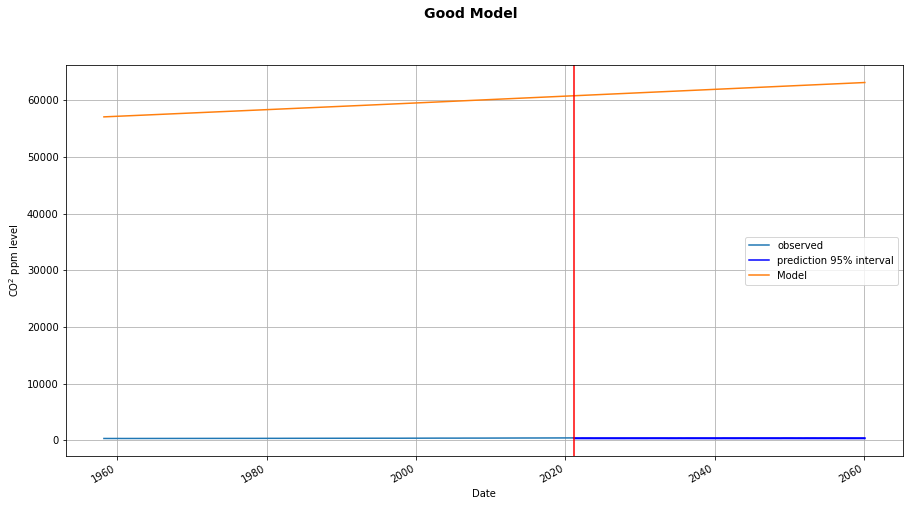

In [65]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Good Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions =  good_t_intercept + good_a * to_predict + good_b * to_predict**2 + good_c2 * np.cos(2 * np.pi * to_predict / 365.25 + good_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()

In [66]:
### IMPORTING THE MODULES 
import io
import numpy as np
import pandas as pd 
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan
import math
import seaborn
from datetime import datetime

#get dataset 
df = pd.read_csv(
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv', 
    header=None, 
    # parse_dates=[0], 
    dtype={1: np.float16}, 
    names=['date', 'level_ppm']
)

#convert the dataframe into a numpy array
co2_data = df.to_numpy()

#Convert dates from strings to number of days since start of 1958
frmt = '%Y-%m-%d'
beginning_date = '1958-1-1'
b_date = datetime.strptime(beginning_date, frmt) #strptime converts the string to datetime object

#calculate days since 1st jan of 1958 to get a numerical t range for modeling
for i in range(len(co2_data)):
    curr_date = co2_data[i,0]
    c_date = datetime.strptime(curr_date, frmt)
    diff = c_date - b_date #subtract current date from the beginning
    co2_data[i,0] = diff.days


t_vals = co2_data[:,0] #time in days since 1st jan, 1958
x_vals = co2_data[:,1] #CO2 levels

n = len(co2_data) #number of observations in dataset
 #15000 days till 2060 from 2017 
 #divide 15000 by 7 to get n_future for weekly data collection expectation at Mauna Loa
n_future = 15000

#preview the numpy array with days since 1st jan on 1st col
#and CO2 levels in ppm on second column
print(co2_data) 

[[87 316.25]
 [94 317.25]
 [101 317.75]
 ...
 [23040 415.75]
 [23047 417.0]
 [23054 416.5]]


In [92]:
%%time
### STAN MODELING 

stan_code = '''
data {
  int <lower=0> n;
  int <lower=0> n_future;
  vector[n] y;
  vector[n] x;
}

parameters {
  //posterior parameters 
  real<lower=0> b; 
  real c2; 
  real<lower=0> intercept;
  real<lower=0> a; 
  real<lower=0> sigma; // Noise
}

model {
  //non-informative gaussian priors
  b ~ normal(0, 5); 
  intercept ~ normal(300, 3);

  //likelihood function 
  for(t in 1:n){
    y[t]~normal(intercept + a*x[t] + b*x[t]^2 + c2*cos(2*pi()*x[t]/365.25), sigma);
  }

}
//for predictions into the future
generated quantities {
  real y_future[n_future];
  for(t in 1:n_future) {
    y_future[t] = normal_rng(intercept + a*(x[n]+t) + b*(x[n]+t)^2 + c2*cos(2*pi()*(x[n]+t)/365.25), sigma);
    }
}
'''

#Compile the model 
stan_model = pystan.StanModel(model_code=stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3254603abd7ddddba46accb03e763bc8 NOW.


CPU times: user 1.16 s, sys: 201 ms, total: 1.36 s
Wall time: 53.6 s


In [99]:
%%time
stan_data = {
    'n': n, #number of days since 1 jan 1958
    'n_future': n_future, #40 years into the future is approximately 15000
    'y': df['level_ppm'],
    'x': df['ordinal']
}
results = stan_model.sampling(data=stan_data)
samples = results.extract()
#Preview the parameters
parameters = ['b','c2','intercept','a','sigma'] 
print(results.stansummary(pars=parameters))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_3254603abd7ddddba46accb03e763bc8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
b         1.4e-10 1.5e-13 6.1e-12 1.3e-10 1.4e-10 1.4e-10 1.5e-10 1.5e-10   1623    1.0
c2          -0.13    0.01    0.69   -1.47   -0.58   -0.15    0.33    1.22   3245    1.0
intercept  281.48    0.07    3.03   275.6  279.42  281.51  283.62  287.31   1651    1.0
a          1.3e-6  2.6e-8  1.3e-6  3.5e-8  3.7e-7  9.0e-7  1.8e-6  4.9e-6   2551    1.0
sigma       27.66  6.3e-3    0.36   26.96   27.41   27.65   27.89   28.36   3206    1.0

Samples were drawn using NUTS at Mon Apr 26 11:01:03 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 2.53 s, sys: 4.07 s, total: 6.6 s
Wall time: